<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/dual-attention/Indian_Pines_msd_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import keras
from keras import regularizers
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, ReLU, PReLU, MaxPool3D, Conv3DTranspose
from keras.layers import Dropout, Input, GlobalAveragePooling2D, multiply, add, Activation, Permute, merge
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
from scipy.stats import entropy
import tensorflow as tf
from keras.layers import Layer

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
# import spectral

init_notebook_mode(connected=True)
%matplotlib inline
#%tensorflow_version 1.x

Using TensorFlow backend.


In [2]:
!pip install -U spectral
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

     |████████████████████████████████| 153kB 3.3MB/s 
  Created wheel for spectral: filename=spectral-0.20-cp36-none-any.whl size=183918 sha256=ddc1d028338019222c45115cee3c56be1f5f2623550911c747e4fa91e615e746
  Stored in directory: /root/.cache/pip/wheels/ad/cf/f3/3cab28f6aed46f15c8db09c6ad678483610426261025e61ff8
Successfully built spectral
--2020-02-01 12:09:18--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   676KB/s    in 9.4s    

2020-02-01 12:09:28 (615 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-02-01 12:09:32--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158

In [0]:
def loadData():
    data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X, y = loadData()

In [7]:
X.shape

(145, 145, 200)

In [8]:
X, y = createImageCubes(X, y, 5)

X.shape, y.shape

((10249, 5, 5, 200), (10249,))

In [0]:
n_bands = 200
target_bands = 15

# Model and Training

In [0]:
# X = X.reshape(-1, 200, 5, 5)
# X.shape

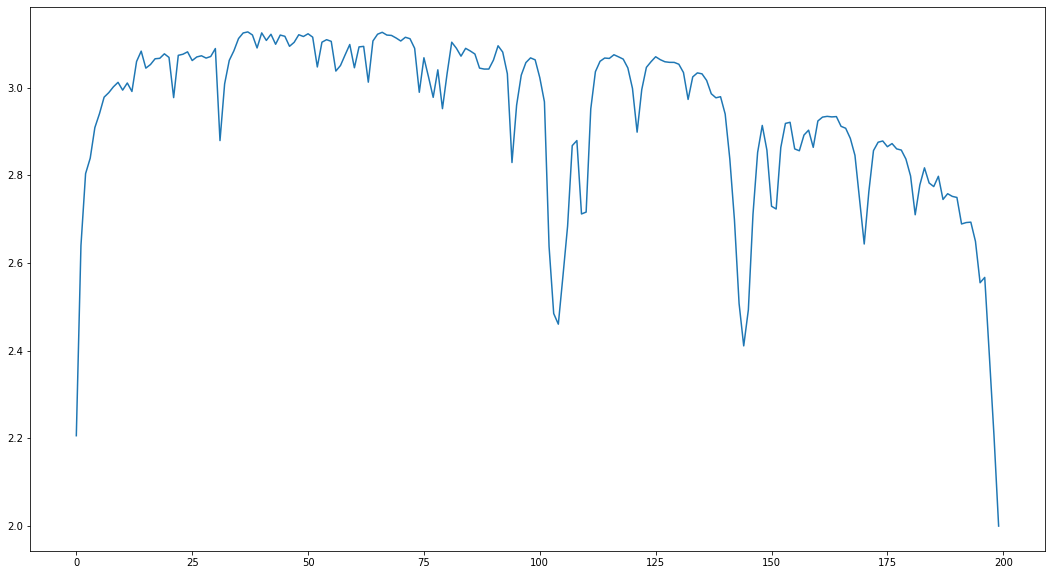

In [11]:
X = X.reshape(-1,5,5,200)
ENTROPY = np.zeros([10249,200])
for b in range(0,10249):  #10249
  band_subset = X[b,:,:,:]
  n_row,n_column,n_band= band_subset.shape
  N = n_row * n_column
  hist = []
  #ENTROPY_per_batch = [] 
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
    band_i = hist[i].reshape(-1)/np.sum(hist[i])
    entr_i = entropy(band_i)
    ENTROPY[b][i] += entr_i  ## the entropy of one band for one batch
    #ENTROPY_per_batch.append(entr_i) #/10249
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-1
  #ENTROPY_per_batch = np.asarray(ENTROPY_per_batch)
  
  ##print(hist.shape)  gives  (200,256)
     ## after looping will be len(list) = 200    

fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(121)
ax1.plot(np.average(ENTROPY,axis =0))









In [0]:
def BAM():
    model = Sequential()
    model.add(Conv2D(filters=64,
                     input_shape=(5, 5, 200),
                     kernel_size=(3,3),
                     strides=1,
                     padding='valid', name="Conv1"))
    model.add(ReLU(name="ReLU1"))
    model.add(GlobalAveragePooling2D(data_format="channels_first"))
    
    model.add(Dense(128))
    model.add(ReLU(name="ReLU2"))
    model.add(Dense(200, activation="sigmoid"))
  
    return model

In [0]:
def DCAE(weight_decay=0.0005):
    model = Sequential()
    model.add(Conv3D(filters=24,
                     input_shape=(200, 5, 5, 1),
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv1"))
    model.add(BatchNormalization(name="BN1"))
    model.add(PReLU(name="PReLU1"))

    model.add(Conv3D(filters=48,
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv2"))
    model.add(BatchNormalization(name="BN2"))
    model.add(PReLU(name="PReLU2"))

    model.add(MaxPool3D(pool_size=(18, 1, 1),
                        strides=(18, 1, 1), name="Pool1"))

    model.add(Conv3DTranspose(filters=24,
                              kernel_size=(9, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(22, 1, 1), name="Deconv1", padding='valid'))
    model.add(BatchNormalization(name="BN3"))
    model.add(PReLU(name="PReLU3"))
    model.add(Conv3DTranspose(filters=1,
                              kernel_size=(25, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(1, 1, 1), name="Deconv2", padding='valid'))
    model.add(BatchNormalization(name="BN4"))
    
    return model

In [0]:
def Ensemble():
    input_layer = Input((5, 5, 200))
    band_activations = BAM()(input_layer)
    # band_activations = Reshape((200, 1, 1))(band_activations)
    
    bam_output = multiply([band_activations, input_layer])
    
    bam_output = Reshape((200, 5, 5, 1))(bam_output)
    # da_output = DA()(input_layer)
    # da_output = Permute((3,1,2), input_shape=(11,11,200))(da_output)
    # da_output = Reshape((200, 11, 11, 1))(da_output)
    output = DCAE()(bam_output)
    
    
    return Model(inputs=input_layer, outputs=output)
    

In [15]:
# model = DCAE(weight_decay=0.0005)
model = Ensemble()
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 5, 200)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          141576      input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 5, 5, 200)    0           sequential_1[1][0]               
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 200, 5, 5, 1) 0           multiply_1[0][0]       

In [0]:
ENTROPY = np.zeros(n_bands)
import skimage.measure
def topkbands(x_predict, topk):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=entropy(np.unique(x_predict[:,i,:,:],return_counts=True)[1],base=2)
  
  
  return ENTROPY.argsort()[-topk:][::-1]

In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20
    # entropy_lst = entropy(hist.transpose())
  info_div = 0
    # band_subset[np.nonzero(band_subset <= 0)] = 1e-20
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [0]:
def MSD2(x_predict,topbandindices):
  ##create band_subset
  x_predict = x_predict.reshape(10249,200,5,5)
  #print(x_predict.shape)                                        ## 10249,200,5,5
  band_subset_list = []
  for i in range(0,len(topbandindices)):
    band_subset_list.append(x_predict[:,i,:,:])     
  band_subset = np.array(band_subset_list)    
  #print(band_subset.shape)                                      ## band_subset.shape = ## 15,10249,5,5
  band_subset = np.stack(band_subset,axis = 1)     
  #print(band_subset.shape)                                      ## required shape is [10249,15,5,5] 
  band_subset = band_subset.reshape(10249,5,5,-1)
  #print(band_subset.shape)                
  xx = []
  for k in range(0,10249):
    xx.append(MeanSpectralDivergence(band_subset[k,:,:,:]))   
                                                                ## then reshape to [10249,5,5,15] 
  print(np.average(np.array(xx)))






In [0]:
def plott(ENTROPY):
  fig = plt.figure(figsize=(40,4))
  ax1 = fig.add_subplot(121)
  ax1.plot(ENTROPY)


In [0]:
ENTROPY = np.zeros(200)
def output_entropy(x_predict):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=entropy(np.unique(x_predict[:,i,:,:],return_counts=True)[1],base=2)
  plott(ENTROPY)

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
import math

class MyLogger(Callback):

  def on_train_end(self,logs=None):
    x_predict = model.predict(X)
    bandlist = topkbands(x_predict, 15)
    with open('BANDLIST.txt', 'w') as filehandle:
      for banditem in bandlist:
        filehandle.write('%s\n' % banditem)  ## Manually download BANDLIST.txt from colab.
    MSD2(x_predict, bandlist)
    

In [22]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=0.1),metrics=['accuracy'])

n_epoch = 50

history = model.fit(X, X.reshape(-1, 200, 5, 5, 1), epochs=n_epoch, shuffle=True, verbose=1, batch_size=64, callbacks=[MyLogger()])





Epoch 1/50





10249/10249 [==============================] - 21s 2ms/step - loss: 9709561.2176 - acc: 5.1211e-04
Epoch 2/50
10249/10249 [==============================] - 5s 447us/step - loss: 9567891.9525 - acc: 4.2912e-05
Epoch 3/50
10249/10249 [==============================] - 5s 442us/step - loss: 9431308.4474 - acc: 1.5924e-05
Epoch 4/50
10249/10249 [==============================] - 5s 441us/step - loss: 9296986.4076 - acc: 1.1513e-05
Epoch 5/50
10249/10249 [==============================] - 5s 444us/step - loss: 9164358.2696 - acc: 3.6101e-06
Epoch 6/50
10249/10249 [==============================] - 5s 443us/step - loss: 9033407.1268 - acc: 3.6882e-06
Epoch 7/50
10249/10249 [==============================] - 5s 443us/step - loss: 8904052.5110 - acc: 3.6882e-06
Epoch 8/50
10249/10249 [==============================] - 5s 443us/step - loss: 8776108.2297 - acc: 3.0442e-06
Epoch 9/50
10249/10249 [==============================] - 5s 442us/step - loss: 8649507.5817 - acc: 2.75

In [23]:
print(len(history.history['loss']))

50


In [24]:
print(model.predict(X).shape)

(10249, 200, 5, 5, 1)
